In [101]:
import numpy as np
import pprint
pp = pprint.PrettyPrinter(depth = 2)
import re
from utils import *
import pickle
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy import stats
from sklearn.metrics import r2_score
from matplotlib.colors import LogNorm
from math import ceil


Load in the data

In [2]:
with open(os.path.join("data", "data_clean_no_letters.pickle"), "rb") as f:
    datar = pickle.load(f)

In [3]:
github_metadata            = datar.github_metadata
google_play_metadata       = datar.google_play_metadata
github_names               = datar.github_names
all_release_metadata       = datar.all_release_metadata
all_reviews_from_github    = datar.all_reviews_from_github

In [4]:
len(github_names)

415

<b>RQ 1 :</b> What is the correlation between app release frequency and user engagement metrics (e.g., number of ratings and installs)?

In [5]:
def extract_version(version_string):
    if version_string is None: return None
    search = re.search('(\d+.\d+.\d+)', version_string)
    return search.group(1) if search else None

In [6]:
def parse_reviews(reviews):
    
    review_metrics = defaultdict(defaultdict)

    for review in reviews:
        version = extract_version(review["reviewCreatedVersion"])
        
        if version is None: continue
        
        if version not in review_metrics.keys():
            review_metrics[version] = {
                "count"         : 0,
                "total_score"   : 0
            }

        review_metrics[version]["count"] += 1
        review_metrics[version]["total_score"] += review["score"]

    return review_metrics

In [7]:
def parse_releases(releases):
    
    release_metrics = dict()
    
    to_datetime = lambda x : datetime.fromisoformat(x[:-1] + '+00:00')
    duration = lambda x : (to_datetime(x["end_date"]) - to_datetime(x["start_date"])).total_seconds()

    for release in releases:
        version = extract_version(release["release_data"]["tag_name"])
        
        if version is None: continue
        
        if version not in release_metrics.keys():
            release_metrics[version] = {
                "duration" : 0
            }
        
        release_metrics[version]["duration"] = duration(release)
    
    return release_metrics

In [8]:
def compute_values_per_version(key):
    
    # Compute update frequencies
    releases        = all_release_metadata[key]
    release_metrics = parse_releases(releases)
    
    # Compute review metrics
    reviews         = all_reviews_from_github[key]
    review_metrics  = parse_reviews(reviews)
    
    for (k, v) in review_metrics.items():
        if v["count"] != 0:
            review_metrics[k]["avg_score"] = v["total_score"] / v["count"]
        else:
            review_metrics[k]["avg_score"] = None
            
    # Join metrics
    metrics = defaultdict(lambda : defaultdict(int))
    
    for version in release_metrics.keys():
        
        for release_name, release_value in release_metrics[version].items():
            metrics[version][release_name] = release_value
            
        for review_name, review_value in review_metrics[version].items():
            metrics[version][review_name] = review_value
            
    return metrics
    

In [9]:
def compute_all_values():
    metrics = dict()
    
    for key in all_release_metadata.keys():
        metrics[key] = compute_values_per_version(key)
        
    return metrics

In [10]:
def flatten_dict(m, param_list):
    output_dict = defaultdict(list)
    for (name, metrics_per_version) in m.items():
        for metrics in metrics_per_version.values():
            
            for param in param_list:
                output_dict[param].append(metrics[param])
                
    return output_dict

In [11]:
# Compute all the metrics
metrics_per_version = compute_all_values()
metrics = flatten_dict(metrics_per_version, ["duration", "count", "avg_score"])

In [12]:
def rq1_plot(x, y, x_label, y_label):
    fig = plt.figure()

    gs = GridSpec(4,4)

    ax_joint = fig.add_subplot(gs[1:4,0:3])
    ax_marg_x = fig.add_subplot(gs[0,0:3])
    ax_marg_y = fig.add_subplot(gs[1:4,3])
    ax_color = fig.add_subplot(gs[0, 3])

    im = ax_joint.hexbin(x, y, cmap = "viridis", gridsize = 25, norm = LogNorm())
    
    fig.colorbar(im, cax = ax_color, orientation = 'vertical')
    
    # Plot best line fit
    z = np.polyfit(x, y, 1) 
    # r_squared = r2_score(x, y)
    ax_joint.plot(np.unique(x), np.poly1d(z)(np.unique(x)), label=("y=%.2fx+%.2f"%(z[0],z[1])))
    
    nbins = 30

    # Plot marginals
    x_bins = np.arange(nbins + 1) * (np.max(x) - np.min(x)) / nbins + np.min(x)
    x_kde = stats.gaussian_kde(x)
    xx = np.linspace(np.min(x), np.max(x), 1000)
    ax_marg_x.hist(x, bins = x_bins, density = True, color="steelblue")
    ax_marg_x.plot(xx, x_kde(xx), color="blue")

    y_bins = np.arange(nbins + 1) * (np.max(y) - np.min(y)) / nbins + np.min(y)
    y_kde = stats.gaussian_kde(y)
    yy = np.linspace(np.min(y), np.max(y), 1000)
    ax_marg_y.hist(y, bins = y_bins, density = True, color="green", orientation="horizontal")
    ax_marg_y.plot(y_kde(yy), yy, color="limegreen")

    # Turn off tick labels on marginals
    plt.setp(ax_marg_x.get_xticklabels(), visible=False)
    plt.setp(ax_marg_y.get_yticklabels(), visible=False)

    # Set labels on joint
    ax_joint.set_xlabel(x_label)
    ax_joint.set_ylabel(y_label)
    
    ax_joint.legend(loc = 'upper left')
    plt.show()

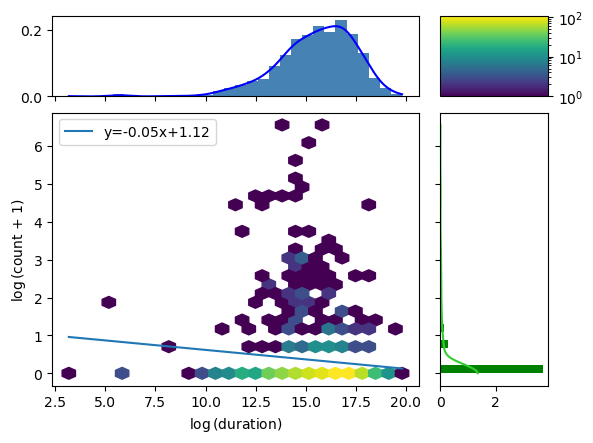

In [14]:
x, y = np.log(np.array(metrics["duration"])), np.log(np.array(metrics["count"]) + 1)
x_label, y_label = r"$\log$(duration)", r"$\log$(count + 1)" 
rq1_plot(x, y, x_label, y_label)

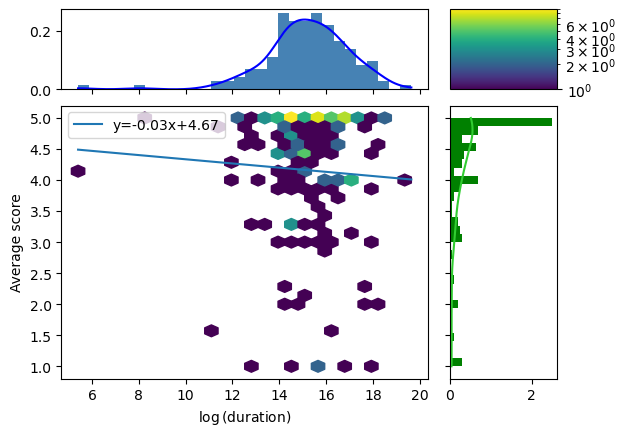

In [15]:
y = np.array(metrics["avg_score"])
x = np.log(np.array(metrics["duration"]))
idxs = y != 0
x, y = x[idxs], y[idxs]
x_label, y_label = r"$\log$(duration)", r"Average score" 
rq1_plot(x, y, x_label, y_label)

<b>RQ 2 : </b>What characteristics are associated with app releases that experience an increasing in average rating of 2 points / 50 %?

In [77]:
def version_of_popularity_increase(app_metrics, is_popularity_increase):
    
    pop_increase_versions = list()
    
    versions = np.sort(np.array(list(app_metrics.keys())))
    
    n = versions.shape[0]
    
    if n <= 1:
        return pop_increase_versions
    
    prev_key = versions[0]
    prev_score = app_metrics[prev_key]["avg_score"]
    prev_count = app_metrics[prev_key]["count"]
    
    for i in range(1, n):
        key     = versions[i]
        score   = app_metrics[key]["avg_score"]
        count   = app_metrics[key]["count"]
        
        if prev_count != 0 and count != 0 and is_popularity_increase(prev_score, score):
            pop_increase_versions.append({
                "prev_key" : prev_key, 
                "key" : key,
                "prev_score" : prev_score,
                "score" : score
                })

        prev_key    = key
        prev_score  = score
        prev_count  = count
        
    return pop_increase_versions

In [126]:
PERCENT_INCREASE = 10
is_popularity_increase = lambda prev, curr : (curr - prev) / prev * 100 >= PERCENT_INCREASE if prev != 0 else False
pop_increases = []

for key, value in metrics_per_version.items():
    l = version_of_popularity_increase(value, is_popularity_increase)  
    if len(l) > 0:
        pop_increases.append([key, l])

print(pop_increases)
print(sum(len(x[1]) for x in pop_increases))

[[np.str_('Domi04151309/Power-App-for-Android'), [{'prev_key': np.str_('1.8.3'), 'key': np.str_('1.8.4'), 'prev_score': 3.0, 'score': 3.6666666666666665}]], [np.str_('LibChecker/LibChecker'), [{'prev_key': np.str_('2.2.2'), 'key': np.str_('2.2.3'), 'prev_score': 4.5, 'score': 5.0}, {'prev_key': np.str_('2.3.2'), 'key': np.str_('2.3.5'), 'prev_score': 3.5, 'score': 5.0}]], [np.str_('apcro/leafpicrevived'), [{'prev_key': np.str_('0.8.5'), 'key': np.str_('0.8.6'), 'prev_score': 3.0, 'score': 5.0}]], [np.str_('ev-map/EVMap'), [{'prev_key': np.str_('0.7.1'), 'key': np.str_('0.7.3'), 'prev_score': 3.0, 'score': 5.0}]], [np.str_('kollerlukas/Camera-Roll-Android-App'), [{'prev_key': np.str_('1.5.2'), 'key': np.str_('1.6.1'), 'prev_score': 4.5, 'score': 5.0}]], [np.str_('openmrs/openmrs-contrib-android-client'), [{'prev_key': np.str_('2.4.1'), 'key': np.str_('2.6.2'), 'prev_score': 3.0, 'score': 3.3333333333333335}]], [np.str_('organicmaps/organicmaps'), [{'prev_key': np.str_('2021.09.14'), 'ke

In [127]:
def datapoints_per_metric(pop_increases, get_metric):
    x = []
    y = []

    for (key, data_per_version) in pop_increases:
        for data in data_per_version:

            prev_version = data["prev_key"]
            version =  data["key"]

            prev_score = data["prev_score"]
            score = data["score"]

            release_metadata = all_release_metadata[key]
            version_per_id = [extract_version(release_metadata[i]["release_data"]["tag_name"]) for i in range(len(release_metadata))]

            id_prev_version = version_per_id.index(prev_version)
            id_curr_version = version_per_id.index(version)


            perc_increase = lambda prev_v, curr_v, f : (f(curr_v, release_metadata) - f(prev_v, release_metadata)) / f(prev_v, release_metadata) * 100 if f(prev_v, release_metadata) != 0 else None

            yval = perc_increase(id_prev_version, id_curr_version, get_metric)
            xval = perc_increase(prev_score, score, lambda x, y : x)
            
            if xval is not None and yval is not None:
                x.append(xval)
                y.append(yval)

    return x, y

Text(0.5, 0.98, 'Percentual increase in values per score increase')

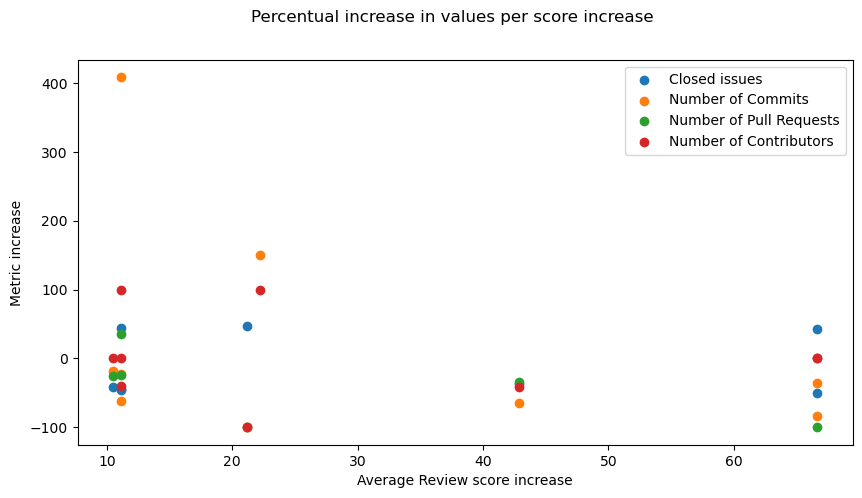

In [128]:
get_metrics = {
    "Closed issues" : lambda id, data : len(data[id]["closed_issues"]),
    "Number of Commits" : lambda id, data : len(data[id]["commits"]),
    "Number of Pull Requests" : lambda id, data : len(data[id]["pull_requests"]),
    "Number of Contributors" : lambda id, data : len(data[id]["contributors"]),
}

keys = list(get_metrics.keys())
n = len(keys)

fig, ax = plt.subplots(1, 1, figsize = (10, 5), sharex=True, sharey=True)


for i in range(n):
    key = keys[i]
    x, y = datapoints_per_metric(pop_increases, get_metrics[key])
    ax.scatter(x, y, label = key)
    
ax.set_xlabel("Average Review score increase")
ax.set_ylabel("Metric increase")
ax.legend()

fig.suptitle("Percentual increase in values per score increase")

Text(0.5, 0.98, 'Percentual increase in values per score increase')

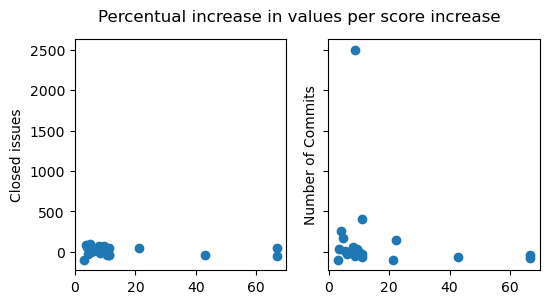

In [ ]:
# get_metrics = {
#     "Closed issues" : lambda id, data : len(data[id]["closed_issues"]),
#     "Number of Commits" : lambda id, data : len(data[id]["commits"]),
# }

# keys = list(get_metrics.keys())
# n = len(keys)
# n_cols = min(3, n)
# n_rows = ceil(n / n_cols)

# fig, axes = plt.subplots(n_rows, n_cols, figsize = (3 * n_cols, 3 * n_rows), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     if i < n:
#         key = keys[i]
#         x, y = datapoints_per_metric(pop_increases, get_metrics[key])
#         ax.scatter(x, y)
        
#         if i // n_cols == n_rows:
#             ax.set_xlabel("Score")
            
#         ax.set_ylabel(key)

# fig.suptitle("Percentual increase in values per score increase")


# x, y = datapoints_per_metric(pop_increases, get_metric)
# plt.scatter(x, y)